In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [9]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df_train = pd.read_csv("../adult/adult.data", header=None, names=column_names)
df_test = pd.read_csv('../adult/adult.test', header=None, names=column_names, skiprows=1)

df_test['income'] = df_test['income'].str.strip().str.rstrip('.')
df_test['income'] = (df_test['income'] == ">50K").astype(int)

df_train['income'] = df_train['income'].str.strip().str.rstrip('.')
df_train['income'] = (df_train['income'] == ">50K").astype(int)

X_train = pd.get_dummies(df_train.drop("income", axis=1))
y_train = df_train["income"]

X_test = pd.get_dummies(df_test.drop("income", axis=1))
y_test = df_test["income"]

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=50))
])

param_grid = {
    'mlp__hidden_layer_sizes': [(32,), (64, 32), (128, 64, 32)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__solver': ['adam', 'sgd'],
}

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

best_model = grid.best_estimator_

y_train_pred = best_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)  # <-- compute F1

print("Training accuracy:", train_acc)
print("Training F1 score:", train_f1)

y_test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)    # <-- compute F1

print("Testing accuracy:", test_acc)
print("Testing F1 score:", test_f1)

Best parameters: {'mlp__activation': 'logistic', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (32,), 'mlp__solver': 'adam'}
Training accuracy: 0.8652375541291729
Training F1 score: 0.6992048258842885
Testing accuracy: 0.8549843375714022
Testing F1 score: 0.6694666106677867


In [7]:
from sklearn.utils.class_weight import compute_sample_weight

In [8]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df_train = pd.read_csv("../adult/adult.data", header=None, names=column_names)
df_test = pd.read_csv('../adult/adult.test', header=None, names=column_names, skiprows=1)

df_test['income'] = df_test['income'].str.strip().str.rstrip('.')
df_test['income'] = (df_test['income'] == ">50K").astype(int)

df_train['income'] = df_train['income'].str.strip().str.rstrip('.')
df_train['income'] = (df_train['income'] == ">50K").astype(int)

X_train = pd.get_dummies(df_train.drop("income", axis=1))
y_train = df_train["income"]

X_test = pd.get_dummies(df_test.drop("income", axis=1))
y_test = df_test["income"]

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


pipe = Pipeline([
    ('mlp', MLPClassifier(max_iter=50, random_state=42))
])

param_grid = {
    'mlp__hidden_layer_sizes': [(32,), (64, 32), (128, 64, 32)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__solver': ['adam', 'sgd'],
}

f1_scorer = make_scorer(f1_score, pos_label=1)
grid = GridSearchCV(pipe, param_grid, cv=3, scoring=f1_scorer, n_jobs=-1)


sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Fit GridSearchCV with sample weights
grid.fit(X_train, y_train, mlp__sample_weight=sample_weights)


best_model = grid.best_estimator_

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# Training metrics
y_train_pred = best_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
print("\nTraining accuracy:", train_acc)
print("Training F1 score:", train_f1)

# Testing metrics
y_test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print("\nTesting accuracy:", test_acc)
print("Testing F1 score:", test_f1)

Best parameters: {'mlp__activation': 'logistic', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (32,), 'mlp__solver': 'adam'}
Best CV accuracy: 0.689228371487535

Training accuracy: 0.8270937624765824
Training F1 score: 0.7078663345786633

Testing accuracy: 0.8143848657944843
Testing F1 score: 0.6810217437196537


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier

column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df_train = pd.read_csv("../adult/adult.data", header=None, names=column_names)
df_test = pd.read_csv('../adult/adult.test', header=None, names=column_names, skiprows=1)

df_test['income'] = df_test['income'].str.strip().str.rstrip('.')
df_test['income'] = (df_test['income'] == ">50K").astype(int)

df_train['income'] = df_train['income'].str.strip().str.rstrip('.')
df_train['income'] = (df_train['income'] == ">50K").astype(int)

X_train = pd.get_dummies(df_train.drop("income", axis=1))
y_train = df_train["income"].values

X_test = pd.get_dummies(df_test.drop("income", axis=1))
y_test = df_test["income"].values

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n_pos = np.sum(y_train)
n_neg = y_train.shape[0] - n_pos
pos_weight = n_neg / n_pos
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32)

class MLPModule(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, activation='sigmoid'):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
        if activation == 'sigmoid':
            self.act = nn.Sigmoid()
        elif activation == 'tanh':
            self.act = nn.Tanh()
        elif activation == 'relu':
            self.act = nn.ReLU()
        else:
            raise ValueError("Invalid activation")

    def forward(self, X):
        X = self.act(self.hidden(X))
        X = self.output(X)  # raw logits for BCEWithLogitsLoss
        return X


net = NeuralNetClassifier(
    MLPModule,
    module__input_dim=X_train.shape[1],
    module__hidden_dim=32,
    module__activation='sigmoid',   # logistic
    criterion=nn.BCEWithLogitsLoss,
    criterion__pos_weight=pos_weight_tensor,
    optimizer=optim.Adam,
    optimizer__weight_decay=0.0001,  # alpha
    max_epochs=50,
    lr=0.001,
    batch_size=64,
    iterator_train__shuffle=True,
    verbose=0,
    train_split=None 
)

param_grid = {
    'module__hidden_dim': [32, 64, 128],         
    'module__activation': ['relu', 'tanh', 'sigmoid'],  
    'optimizer__weight_decay': [0.0001, 0.001, 0.01], 
    'optimizer': [torch.optim.Adam, torch.optim.SGD],  
}

gs = GridSearchCV(net, param_grid, cv=3, scoring=f1_scorer, refit=True, verbose=1)
gs.fit(X_train.astype(np.float32), y_train.astype(np.float32).reshape(-1, 1))

best_model = gs.best_estimator_
y_train_pred = best_model.predict(X_train.astype(np.float32))
y_test_pred = best_model.predict(X_test.astype(np.float32))

print("Best parameters:", gs.best_params_)
print("Best CV accuracy:", gs.best_score_)

print("\nTraining accuracy:", accuracy_score(y_train, y_train_pred))
print("Training F1 score:", f1_score(y_train, y_train_pred))
print("Testing accuracy:", accuracy_score(y_test, y_test_pred))
print("Testing F1 score:", f1_score(y_test, y_test_pred))


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'module__activation': 'sigmoid', 'module__hidden_dim': 128, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__weight_decay': 0.0001}
Best CV accuracy: 0.6902382557115292

Training accuracy: 0.8364607966585793
Training F1 score: 0.720633754787262
Testing accuracy: 0.8163503470302806
Testing F1 score: 0.6821853741496599


**sklearn MLPLearner**
```
Best parameters: {'mlp__activation': 'logistic', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (64, 32), 'mlp__solver': 'adam'}

Training accuracy: 0.8681551549399589
Training F1 score: 0.7082172228641338

Testing accuracy: 0.8546772311283091
Testing F1 score: 0.6702898550724637
```

**sklearn with weights**
```
Best parameters: {'mlp__activation': 'logistic', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (32,), 'mlp__solver': 'adam'}

Best CV accuracy: 0.689228371487535

Training accuracy: 0.8270937624765824
Training F1 score: 0.7078663345786633

Testing accuracy: 0.8143848657944843
Testing F1 score: 0.6810217437196537
```

**Pytorch + Skorch**
```
Best parameters: {'module__activation': 'sigmoid', 'module__hidden_dim': 128, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__weight_decay': 0.0001}

Best CV accuracy: 0.6902382557115292

Training accuracy: 0.8364607966585793
Training F1 score: 0.720633754787262
Testing accuracy: 0.8163503470302806
Testing F1 score: 0.6821853741496599
```

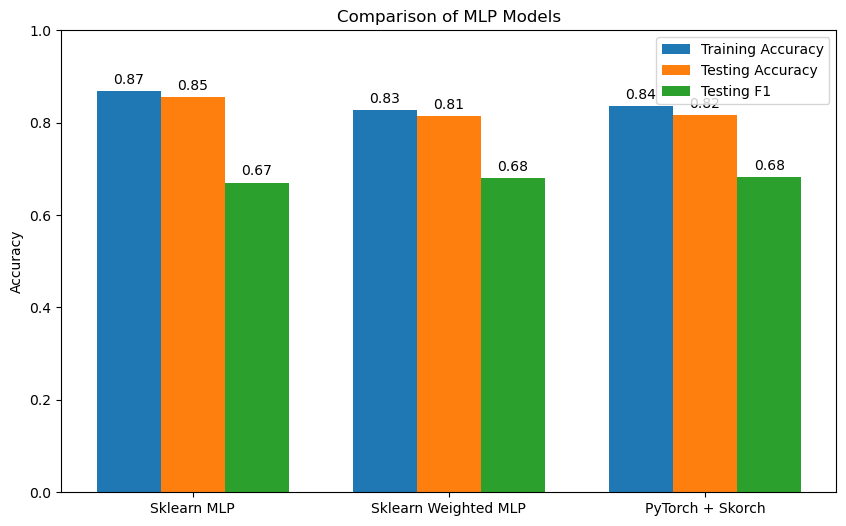

In [12]:
models = ['Sklearn MLP', 'Sklearn Weighted MLP', 'PyTorch + Skorch']
train_acc = [0.8681551549399589, 0.8270937624765824, 0.8364607966585793]
test_acc = [0.8546772311283091, 0.8143848657944843, 0.8163503470302806]
test_f1 = [0.6702898550724637, 0.6810217437196537, 0.6821853741496599]

x = np.arange(len(models))  
width = 0.25 

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, train_acc, width, label='Training Accuracy')
rects2 = ax.bar(x, test_acc, width, label='Testing Accuracy')
rects3 = ax.bar(x + width, test_f1, width, label='Testing F1')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison of MLP Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()

# Add value labels on top of bars
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()
